## 4. Preprocessing position for decoding

To decode, we need to:
1. Process position from pixel to cm; calculate speed. Table involved: IntervalPositionInfo
2. Linearize position (project 2D position to 1D track graph). Table involved: IntervalLinearizedPosition

In [1]:
%reload_ext autoreload
%autoreload 2

In [1]:
import spyglass as nd
import pandas as pd
import matplotlib.pyplot as plt
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename
from spyglass.common import IntervalList
from spyglass.common.common_position import IntervalPositionInfo, PositionInfoParameters
from spyglass.common.common_position import IntervalPositionInfoSelection
from spyglass.common.common_position import IntervalLinearizationSelection
from spyglass.common.common_position import IntervalLinearizedPosition
from spyglass.common.common_position import TrackGraph
from spyglass.shijiegu.Analysis_SGU import EpochPos

[2025-04-19 16:37:03,629][INFO]: Connecting shijiegu-alt@lmf-db.cin.ucsf.edu:3306
[2025-04-19 16:37:03,664][INFO]: Connected shijiegu-alt@lmf-db.cin.ucsf.edu:3306


In [2]:
# test start

In [3]:
PositionInfoParameters & {'position_info_param_name': 'default'}

position_info_param_name name for this set of parameters,max_separation max distance (in cm) between head LEDs,max_speed max speed (in cm / s) of animal,position_smoothing_duration size of moving window (in seconds),speed_smoothing_std_dev smoothing standard deviation (in seconds),head_orient_smoothing_std_dev smoothing std deviation (in seconds),"led1_is_front first LED is front LED and second is back LED, else first LED is back",is_upsampled upsample the position to higher sampling rate,upsampling_sampling_rate The rate to be upsampled to,upsampling_interpolation_method see pandas.DataFrame.interpolation for list of methods
default,9.0,300.0,0.125,0.1,0.001,1,0,nan,linear


In [4]:
PositionInfoParameters & {'position_info_param_name': 'default_decoding'}

position_info_param_name name for this set of parameters,max_separation max distance (in cm) between head LEDs,max_speed max speed (in cm / s) of animal,position_smoothing_duration size of moving window (in seconds),speed_smoothing_std_dev smoothing standard deviation (in seconds),head_orient_smoothing_std_dev smoothing std deviation (in seconds),"led1_is_front first LED is front LED and second is back LED, else first LED is back",is_upsampled upsample the position to higher sampling rate,upsampling_sampling_rate The rate to be upsampled to,upsampling_interpolation_method see pandas.DataFrame.interpolation for list of methods
default_decoding,9.0,300.0,0.125,0.1,0.001,1,1,500.0,linear


In [5]:
# test end

### The only cell to be edited:

In [6]:
nwb_file_name = 'julio20230811.nwb'

### Run the rest

In [7]:
from spyglass.common.common_nwbfile import Nwbfile
from spyglass.utils.nwb_helper_fn import get_all_spatial_series,get_nwb_file

nwb_copy_file_name = get_nwb_copy_filename(nwb_file_name)

In [8]:
nwb_copy_file_name = get_nwb_copy_filename(nwb_file_name)
epochs = (EpochPos() & {'nwb_file_name': nwb_copy_file_name}).fetch('epoch')

EpochPos() & {'nwb_file_name': nwb_copy_file_name}

nwb_file_name name of the NWB file,epoch the session epoch for this task and apparatus(1 based),epoch_name TaskEpoch or IntervalList,position_interval IntervalPositionInfo
julio20230811_.nwb,1,01_Seq2Sleep1,pos 0 valid times
julio20230811_.nwb,2,02_Seq2Session1,pos 1 valid times
julio20230811_.nwb,3,03_Seq2Sleep2,pos 2 valid times
julio20230811_.nwb,4,04_Seq2Session2,pos 3 valid times
julio20230811_.nwb,5,05_Seq2Sleep3,pos 4 valid times
julio20230811_.nwb,6,06_Seq2Session3,pos 5 valid times
julio20230811_.nwb,7,07_Seq2Session4,pos 6 valid times
julio20230811_.nwb,8,08_Seq2Sleep4,pos 7 valid times
julio20230811_.nwb,9,09_Seq2Session5,pos 8 valid times
julio20230811_.nwb,10,10_Seq2Sleep5,pos 9 valid times


In [9]:
position_interval = (EpochPos() & {'nwb_file_name': nwb_copy_file_name}).fetch("position_interval")

In [10]:
# add default calculation parameters
for pos_intvl in position_interval:
    IntervalPositionInfoSelection.insert1(
        {'nwb_file_name': nwb_copy_file_name,
         'interval_list_name': pos_intvl,
         'position_info_param_name': 'default' #default parameters are in the database already
        }, skip_duplicates=True)

    IntervalPositionInfoSelection.insert1(
        {'nwb_file_name': nwb_copy_file_name,
         'interval_list_name': pos_intvl,
         'position_info_param_name': 'default_decoding' #upsampled for decoding, default parameters are in the database already
        }, skip_duplicates=True)

IntervalPositionInfo.populate({'nwb_file_name': nwb_copy_file_name})

[16:37:11][INFO] Spyglass: Computing position for: {'position_info_param_name': 'default', 'nwb_file_name': 'julio20230811_.nwb', 'interval_list_name': 'pos 0 valid times'}
[16:37:11][INFO] Spyglass: Writing new NWB file julio20230811_ULTZNC0WZ5.nwb
[2025-04-19 16:37:12,432][WARNING]: Skipped checksum for file with hash: e0ca95fd-17e3-46d1-5c25-c55bd2a535fa, and path: /stelmo/nwb/raw/julio20230811_.nwb
[2025-04-19 16:37:12,840][WARNING]: Skipped checksum for file with hash: e0ca95fd-17e3-46d1-5c25-c55bd2a535fa, and path: /stelmo/nwb/raw/julio20230811_.nwb
[16:37:15][INFO] Spyglass: Computing position for: {'position_info_param_name': 'default_decoding', 'nwb_file_name': 'julio20230811_.nwb', 'interval_list_name': 'pos 0 valid times'}
[16:37:16][INFO] Spyglass: Writing new NWB file julio20230811_SB5GKSOZHB.nwb
[2025-04-19 16:37:16,780][WARNING]: Skipped checksum for file with hash: e0ca95fd-17e3-46d1-5c25-c55bd2a535fa, and path: /stelmo/nwb/raw/julio20230811_.nwb
[2025-04-19 16:37:16,79

In [11]:
#%debug

In [12]:
# linearization is only for maze run session
epochs = (EpochPos() & {'nwb_file_name': nwb_copy_file_name}).fetch('epoch')
position_interval = []
for e in epochs:
    key = {'nwb_file_name': nwb_copy_file_name,'epoch':e}
    epoch_name = (EpochPos() & key).fetch1('epoch_name')
    position_interval_name = (EpochPos() & key).fetch1('position_interval')
    if epoch_name.split('_')[1][4:8] == 'Sess':
        position_interval.append(position_interval_name)

In [13]:
for pos_intvl in position_interval:
    IntervalLinearizationSelection.insert1(
        {'position_info_param_name': 'default',
         'nwb_file_name': nwb_copy_file_name,
         'interval_list_name': pos_intvl, #'pos 1 valid times',
         'track_graph_name': '4 arm lumped 2023',
         'linearization_param_name': 'default'
        }, replace=True)
    
    IntervalLinearizationSelection.insert1(
        {'position_info_param_name': 'default_decoding',
         'nwb_file_name': nwb_copy_file_name,
         'interval_list_name': pos_intvl, #'pos 1 valid times',
         'track_graph_name': '4 arm lumped 2023',
         'linearization_param_name': 'default'
        }, replace=True)

IntervalLinearizedPosition().populate({'nwb_file_name': nwb_copy_file_name})

[16:38:56][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizationSelection -> spyglass.linearization.v0.main.IntervalLinearizationSelection
Please use the new location.
[16:38:56][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizationSelection -> spyglass.linearization.v0.main.IntervalLinearizationSelection
Please use the new location.
[16:38:56][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizationSelection -> spyglass.linearization.v0.main.IntervalLinearizationSelection
Please use the new location.
[16:38:56][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizationSelection -> spyglass.linearization.v0.main.IntervalLinearizationSelection
Please use the new location.
[16:38:56][WARNING] Spyglass: Deprecation: this class has been m

In [14]:
IntervalLinearizedPosition & {'nwb_file_name': nwb_copy_file_name}

[16:40:39][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


position_info_param_name name for this set of parameters,nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,track_graph_name,linearization_param_name name for this set of parameters,analysis_file_name name of the file,linearized_position_object_id
default,julio20230811_.nwb,pos 1 valid times,4 arm lumped 2023,default,julio20230811_X45D9RUWCO.nwb,186af529-3b3b-496d-9191-4b46c9c9d74f
default,julio20230811_.nwb,pos 3 valid times,4 arm lumped 2023,default,julio20230811_NSPGVK2O3Q.nwb,7c05282f-30fb-4af4-992b-51d80b010191
default,julio20230811_.nwb,pos 5 valid times,4 arm lumped 2023,default,julio20230811_3LPCYFA08I.nwb,a0e93dc5-6758-44c1-b7df-2b18b37048f2
default,julio20230811_.nwb,pos 6 valid times,4 arm lumped 2023,default,julio20230811_WGQJLGKQ4V.nwb,98425e0e-46a6-4573-878c-02000ad226b8
default,julio20230811_.nwb,pos 8 valid times,4 arm lumped 2023,default,julio20230811_TIKPG9S2P9.nwb,e07f9fb3-21ec-4d0d-800f-9b1641d2883e
default_decoding,julio20230811_.nwb,pos 1 valid times,4 arm lumped 2023,default,julio20230811_VEGGO3L4VQ.nwb,49182c14-d715-4def-aff6-71b7ec541820
default_decoding,julio20230811_.nwb,pos 3 valid times,4 arm lumped 2023,default,julio20230811_900ZUJ571Q.nwb,2fc9aa8a-dbf0-452b-9bcd-5824d4200d96
default_decoding,julio20230811_.nwb,pos 5 valid times,4 arm lumped 2023,default,julio20230811_MQ9H1NI5CP.nwb,ab6a19d8-f5c5-486f-aaf5-daf1f387e2dd
default_decoding,julio20230811_.nwb,pos 6 valid times,4 arm lumped 2023,default,julio20230811_ZS628HNU00.nwb,0feac71d-8930-4ef0-90ab-776c800a3124
default_decoding,julio20230811_.nwb,pos 8 valid times,4 arm lumped 2023,default,julio20230811_6SRFD1FYD6.nwb,1d9935be-ae71-4ef6-9653-42ccdade9b74


#### check one interval

[16:40:39][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
[16:40:39][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


Text(0.5, 1.0, 'Linear Position')

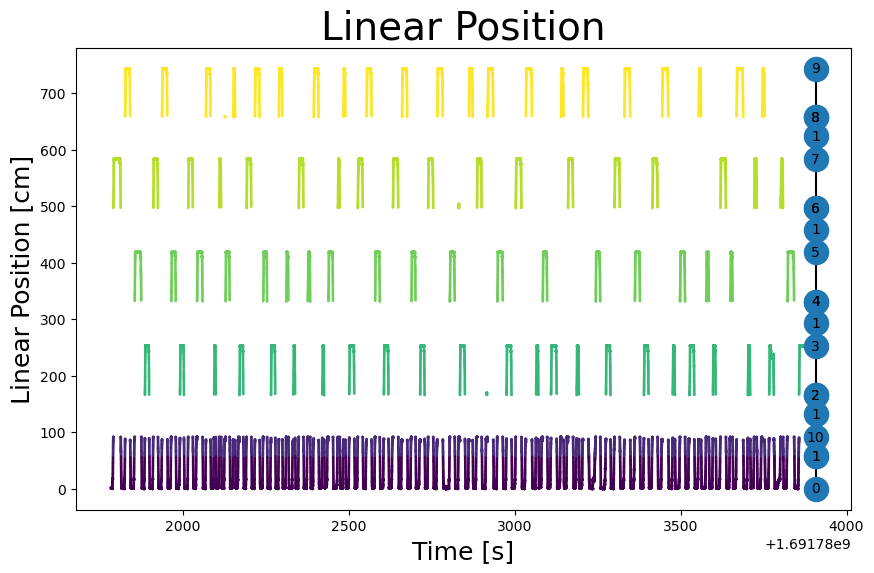

In [15]:
graph = TrackGraph() & {'track_graph_name': '4 arm lumped 2023'}

linear_position_df= (IntervalLinearizedPosition() &
                     {'position_info_param_name': 'default',
                      'nwb_file_name': nwb_copy_file_name,
                      'interval_list_name': 'pos 3 valid times',
                      'track_graph_name': '4 arm lumped 2023',
                      'linearization_param_name': 'default',
                     }).fetch1_dataframe()

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(linear_position_df.index,
            linear_position_df.linear_position,
            c=linear_position_df.track_segment_id,
            s=1)
graph.plot_track_graph_as_1D(
    ax=ax,
    axis='y',
    other_axis_start=linear_position_df.index[-1] + 10)

ax.set_xlabel('Time [s]', fontsize=18)
ax.set_ylabel('Linear Position [cm]', fontsize=18)
ax.set_title('Linear Position', fontsize=28)

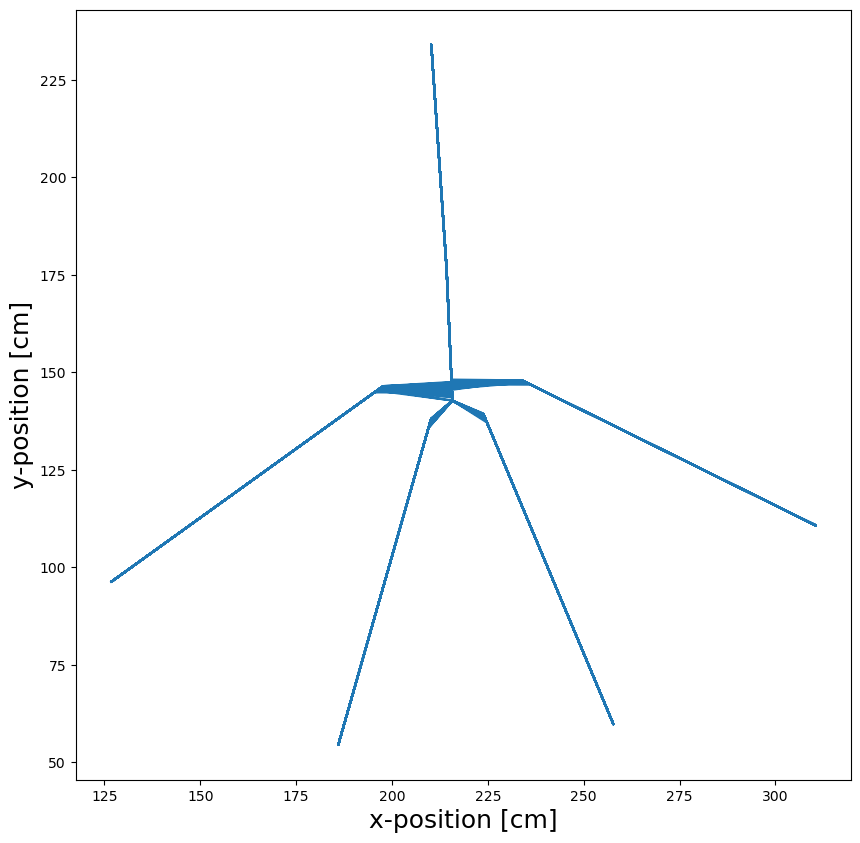

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#ax.plot(position_info.head_position_x, position_info.head_position_y,
#        color='lightgrey', alpha=0.7, zorder=0)
ax.set_xlabel('x-position [cm]', fontsize=18)
ax.set_ylabel('y-position [cm]', fontsize=18)
ax.plot(linear_position_df.projected_x_position, linear_position_df.projected_y_position)